In [1]:
import sys, os
import pandas as pd
import numpy as np
import json
import re
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix, pp_matrix_from_data
pd.options.mode.chained_assignment = None
data_folder = "../Captures/Data_11_9"
data_path = os.path.abspath(data_folder)
ip = '192.168.1.187'
first_run = True

In [2]:
th_pattern = re.compile('^chrome\-\d*\-0\-0\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
sd_th_pattern = re.compile('^chrome\-5\-\d*\.\d*\-0\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
lat_pattern = re.compile('^chrome\-5\-0\-\d*\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
sd_lat_pattern = re.compile('^chrome\-5\-0\-50\-\d*\-0\-0\-[0-9]+\-[0-9]+\.json')
loss_pattern = re.compile('^chrome\-5\-0\-50\-0\-[0-9]\-0\-[0-9]+\-[0-9]+\.json')
sd_loss_pattern = re.compile('^chrome\-[0-9]\-0\-50\-0\-2\-\d*\.\d*\-[0-9]+\-[0-9]+\.json')
patterns = [th_pattern, sd_th_pattern, lat_pattern, sd_lat_pattern , loss_pattern , sd_loss_pattern]

In [3]:
%run "../scripts/helper_functions.py"

In [47]:
%run "../scripts/pcap2csv-scapy-generic.py" {data_path}
data = {}

 ** (tshark:473134) 13:36:14.915205 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 918: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_REACHED"
 ** (tshark:473169) 13:36:16.711093 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 822: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_REACHED"
 ** (tshark:473198) 13:36:18.191850 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 30: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_REACHED"
 ** (tshark:473214) 13:36:19.909004 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 49: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_REACHED"
 ** (tshark:473280) 13:36:22.996787 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 1812: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_REACHED"
 ** (tshark:473292) 13:36:24.214741 [Epan WARNING] -- Dissector bug, protocol H.261, in packet 462: epan/tvbuff.c:4590: failed assertion "DISSECTOR_ASSERT_NOT_RE

## Media identification functions

In [4]:
def filter_ptype(x):
    if type(x) != str and math.isnan(x):
        return x
    x = str(x)
    if ',' in x:
        return str(int(float(x.split(',')[0])))
    return str(int(float(x)))

if first_run:
    webrtc_dirs = []
    vcas = set()
    for dirname in os.listdir(data_path):
        vca = dirname.split('_')[1]
        vcas.add(vca)
        webrtc_dirs.append(data_path+'/'+dirname+f'/{vca}/webrtc/')
    webrtc_files = []
    for webrtc_dir in webrtc_dirs:
        for f in os.listdir(webrtc_dir):
            if '.json' in f:
                webrtc_files.append(webrtc_dir+f)
    # webrtc_files = [webrtc_dir+f for f in os.listdir(webrtc_dir) for webrtc_dir in webrtc_dirs if '.json' in f]
    cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker','rtp.padding','rtp.ext','rtp.ext.len','rtcp.pt','rtcp.senderssrc','rtcp.ssrc.high_seq','rtcp.ssrc.dlsr','rtcp.psfb.fmt', 'rtcp.rtpfb.fmt','rtcp.sender.octetcount']
    file_map = {}
    for webrtc_filename in webrtc_files:
        idx = webrtc_filename.index('webrtc')
        vca = webrtc_filename.split('-')[0]
        pref = vca+'-' + os.path.basename(webrtc_filename)
        net_dir = webrtc_filename[:idx]+f'captures/'
        net_filename = [net_dir+x for x in os.listdir(net_dir) if x.endswith('.csv')][0]
        if not os.path.exists(net_filename):
            print("network file does not exist %s" % net_filename)
            continue
        
        df_webrtc = get_webrtc(webrtc_filename)
        df_net = pd.read_csv(net_filename, header=None, sep='\t', names=cols, lineterminator='\n', encoding='ascii')
        
        df_net = df_net[(df_net["ip.dst"] == ip) & (~pd.isna(df_net["rtp.ssrc"]))]
        
        df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(filter_ptype)
        
        time_col = "frame.time_epoch"


        #dur = df_net[time_col].max() - df_net[time_col].min()
        #if dur > 150:
        #    continue        
        df_rtp = df_net[~pd.isna(df_net["rtp.p_type"])]
        #df_rtp =  df_net[df_net["rtp.p_type"] == "98"]

        (webrtc_min_time, webrtc_max_time) = (df_webrtc["ts"].min(), df_webrtc["ts"].max())
        (pcap_min_time, pcap_max_time) = (df_rtp[time_col].min(), df_rtp[time_col].max())
        
        if webrtc_max_time < pcap_min_time or pcap_max_time < webrtc_min_time:
            print(webrtc_filename)
            continue
        #df_netml = get_net_stats(df_net)
        file_map[pref] = {"webrtc": df_webrtc, "pcap": df_net, "rtp": df_rtp, "vca": vca}  

In [5]:
c = 0
if first_run:
    dirlist = os.listdir(data_folder)
    cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker','rtp.padding','rtp.ext','rtp.ext.len','rtcp.pt','rtcp.senderssrc','rtcp.ssrc.high_seq','rtcp.ssrc.dlsr','rtcp.psfb.fmt', 'rtcp.rtpfb.fmt','rtcp.sender.octetcount']
    # cols= ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type']
    file_map = {}
    for dirname in dirlist:
        vca = dirname.split('_')[1]
        webrtc_filename = glob.glob(f"{data_folder}/{dirname}/{vca}/webrtc/*.json")[0]
        pcap_filename = glob.glob(f"{data_folder}/{dirname}/{vca}/captures/*.pcap")[0]
        pref = os.path.basename(webrtc_filename)
        net_csv_filename = pcap_filename[:-4] + "csv"

        if not os.path.exists(net_csv_filename):
            pcap2csv(pcap_filename)

        df_webrtc = get_webrtc(webrtc_filename)

        df_net = pd.read_csv(net_csv_filename, header=None, sep='\t', names=cols)
        df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(filter_ptype)
        
        # df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(filter_ptype)
        df_net = df_net[(df_net["ip.dst"] == ip) & (~pd.isna(df_net["rtp.ssrc"]))]
        df_net['udp.length'] = df_net['udp.length'].astype('float64') 
        df_rtp = df_net[~pd.isna(df_net["rtp.p_type"])]
        df_rtp['rtp.p_type'] = df_rtp['rtp.p_type'].apply(filter_ptype)
        #df_rtp =  df_net[df_net["rtp.p_type"] == "98"]
        time_col = "frame.time_epoch"

        df_rtp[time_col] = df_rtp[time_col].astype('float64') 
        (webrtc_min_time, webrtc_max_time) = (df_webrtc["ts"].min(), df_webrtc["ts"].max())
        (pcap_min_time, pcap_max_time) = (df_rtp[time_col].min(), df_rtp[time_col].max())
        
        if webrtc_max_time < pcap_min_time or pcap_max_time < webrtc_min_time:
            continue
        #df_netml = get_net_stats(df_net)
        file_map[pref] = {"webrtc": df_webrtc, "pcap": df_net, "rtp": df_rtp, "vca": vca}  
        c += 1
print(c)

460


In [6]:
r = file_map['chrome-5-0-50-0-2-0.0-1667885436-1667885508.json']['rtp']
w = file_map['chrome-5-0-50-0-2-0.0-1667885436-1667885508.json']['webrtc']
print(r['frame.time_epoch'].min())
print(w['ts'].min())

1667885469.3982475
1667885469


In [7]:
import pickle

if first_run:
    with open('../Intermediates/' + data_folder.split('/')[-1]+'_file_map.pkl', 'wb') as handle:
        pickle.dump(file_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('../Intermediates/' + data_folder.split('/')[-1]+'_file_map.pkl', 'rb') as handle:
    file_map = pickle.load(handle)

In [9]:
if first_run:
    df_list = []
    trace_id = 1
    for k in file_map:
        vca = file_map[k]['vca']
        file_map[k]['pcap']['vca'] = vca
        file_map[k]['rtp']['vca'] = vca
        file_map[k]['webrtc']['vca'] = vca

        file_map[k]['pcap']['trace'] = k
        file_map[k]['rtp']['trace'] = k
        file_map[k]['webrtc']['trace'] = k

        file_map[k]['pcap']['trace_id'] = trace_id
        file_map[k]['rtp']['trace_id'] = trace_id
        file_map[k]['webrtc']['trace_id'] = trace_id

        trace_id += 1

        df_list.append(file_map[k]['pcap'])
    df_net = pd.concat(df_list).reset_index()
    filename = data_folder.split('/')[-1]+'_df_net.csv'
    df_net.to_csv(f'../Intermediates/{filename}')

[ 97  98  99  32  36  17  78  60  58  25  28 109  63  56  41  30   5  18]
teams
(1375289, 29)
meet
(237143, 29)


/home/taveesh/Documents/PhD-Research/vca-qoe-inference/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


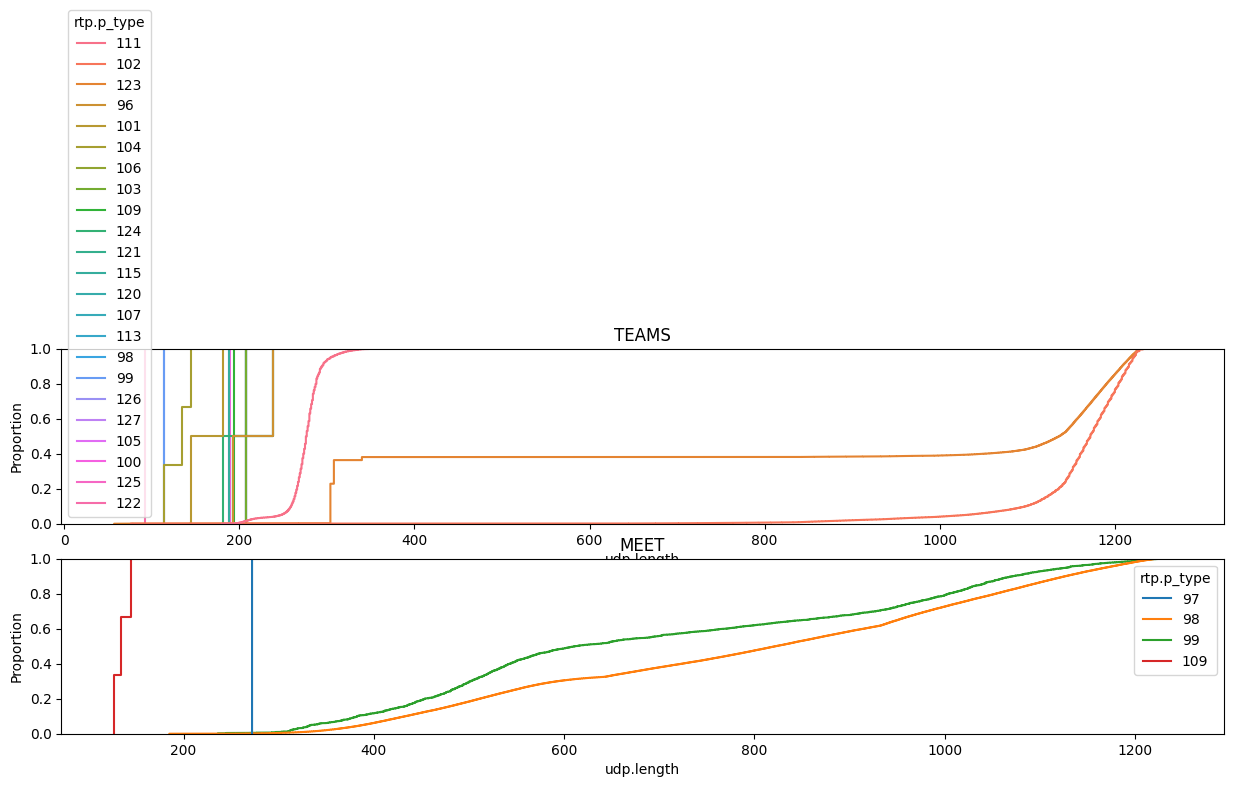

In [10]:
df_net = pd.read_csv('../Intermediates/' + data_folder.split('/')[-1]+'_df_net.csv')

print(df_net[df_net['vca'] == 'meet']['rtp.p_type'].unique())

fig, ax = plt.subplots(len(vcas))
fig.set_figheight(5)
fig.set_figwidth(15)
for i, vca in enumerate(vcas):
    print(vca)
    cdf_data = df_net[(df_net['vca'] == vca)]
    cdf_data['rtp.p_type'] = cdf_data['rtp.p_type'].apply(lambda x: int(x))
    cdf_data = cdf_data[cdf_data['rtp.p_type'] > 95]
    print(cdf_data.shape)
    cdf_data['rtp.p_type'] = cdf_data['rtp.p_type'].apply(lambda x: str(x))
    sns.ecdfplot(data=cdf_data, x="udp.length", hue="rtp.p_type", ax=ax[i]).set_title(vca.upper())

In [11]:
percentiles= [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]
df_net[(df_net['vca'] == 'teams')&(df_net['rtp.p_type'] == '123')]['udp.length'].mode()

Series([], Name: udp.length, dtype: float64)

In [12]:
def label_video_rtp(df_net, vca):
    results = []
    df_vca = df_net[df_net['vca'] == vca]
    df_vca['is_video_actual'] = 0
    for trace_id in df_vca.trace_id.unique():
        df_trace = df_vca[df_vca['trace_id'] == trace_id]
        top_two = df_trace.groupby(['rtp.p_type'])['udp.length'].mean().nlargest(2).index.tolist()
        condition = ((df_trace['rtp.p_type'].isin(top_two)) & ((df_trace['udp.length'] > 304)))
        df_trace.loc[condition, 'is_video_actual'] = 1
        df_trace.loc[~condition, 'is_video_actual'] = 0
        results.append(df_trace)
    res = pd.concat(results)
    return res

In [13]:
def label_video_non_rtp(df_net, vca):
    df_vca = df_net[df_net['vca'] == vca]
    dfs_trace = []
    thresh = 400
    for k in df_vca['trace'].unique():
        df_trace = df_vca[df_vca['trace'] == k]
        df_trace['is_video_pred'] = 0
        is_in_range = ((df_trace['udp.length'] > thresh))
        df_trace.loc[is_in_range, 'is_video_pred'] = 1
        df_trace.loc[~is_in_range, 'is_video_pred'] = 0
        dfs_trace.append(df_trace)
    return pd.concat(dfs_trace)

## Media classification

In [14]:
actual_labelled = []
size_range_map = {}
for vca in vcas:
    rtp_labelled = label_video_rtp(df_net, vca)
    actual_labelled.append(rtp_labelled)
df_rtp_labelled = pd.concat(actual_labelled)

teams
1    1280387
0      94977
Name: is_video_pred, dtype: int64
1    1310935
0      64429
Name: is_video_actual, dtype: int64
meet
1    215884
0     21275
Name: is_video_pred, dtype: int64
1    229521
0      7638
Name: is_video_actual, dtype: int64


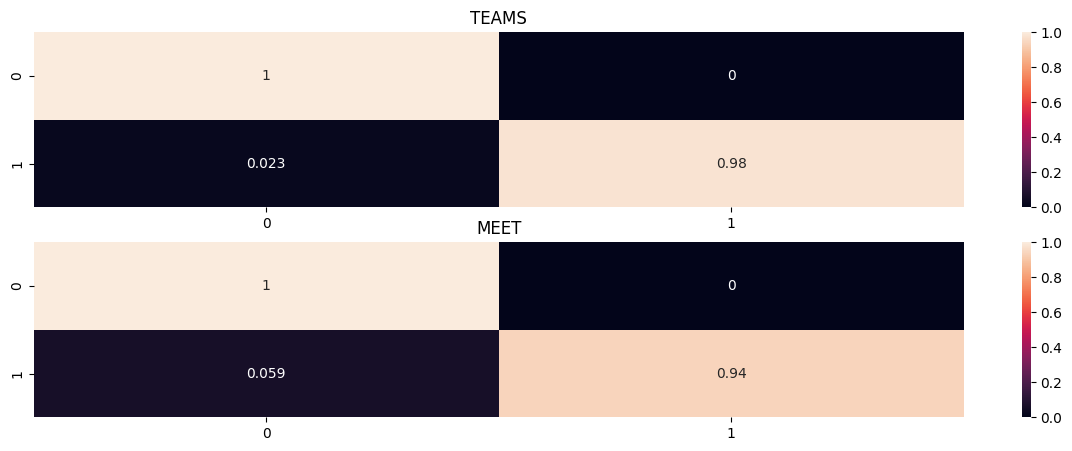

In [15]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)
to_concat = []
for vca in vcas:
    to_concat.append(label_video_non_rtp(df_rtp_labelled, vca))
df_net = pd.concat(to_concat)

for k in file_map:
    file_map[k]['pcap'] = df_net[df_net['trace'] == k]

# ooo_new = None
# ooo_list = []
# for k in file_map:
#     name_split = k.split('-')
#     vca = file_map[k]['vca']
#     df_file = df_net[df_net['trace'] == k]
#     df_file['rtp.ts_rel'] = 0
#     rtp_ts = {}
#     for idx, row in df_file.iterrows():
#         if row['rtp.timestamp'] not in rtp_ts:
#             rtp_ts[row['rtp.timestamp']] = len(rtp_ts)+1
#         df_file.at[idx, 'rtp.ts_rel'] = rtp_ts[row['rtp.timestamp']]
#     df_file['rtp.ts_rel_diff'] = df_file['rtp.ts_rel'].diff()
    # file_map[k]['pcap'] = df_file
    # df_file = df_file[df_file['is_video_actual'] == 1]
    # df_file['frame.time_relative'] = df_file['frame.time_relative'].astype(float)
    # df_file['udp.length_rel'] = df_file['udp.length'].diff()
    # df_file['ooo_status'] = 'In order'
    # df_file.loc[df_file['rtp.ts_rel_diff'] < 0, 'ooo_status'] = 'Out of order'
    # # print(ooo[['rtp.ts_rel_diff', 'udp.length_rel']].describe())
    # df_ooo = df_file[df_file['ooo_status'] == 'Out of order']
    # ooo_list.append(df_ooo)
    # max_neg_diff = df_ooo['rtp.ts_rel_diff'].min()
    # print(f'File = {k} | Number of packets out of order = {len(df_ooo)} | Min RTP timestamp difference = {max_neg_diff}')

fig, ax = plt.subplots(len(vcas))
fig.set_figheight(5)
fig.set_figwidth(15)
for i, vca in enumerate(vcas):
    df_vca = df_net[df_net['vca'] == vca]
    print(vca)
    print(df_vca["is_video_pred"].value_counts())
    print(df_vca["is_video_actual"].value_counts())
    cm = confusion_matrix(df_vca["is_video_actual"], df_vca["is_video_pred"])
    np.set_printoptions(3)
    cm_frac = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_frac, annot=True, ax=ax[i]).set_title(vca.upper())
plt.savefig(f"plots/cm_video.pdf")

## Frame identification

In [16]:
# dfr = pd.concat(ooo_list)
# dfr[dfr['vca'] == 'meet'][['rtp.ts_rel_diff', 'udp.length_rel']].describe(percentiles=percentiles)

In [17]:
# dfr[dfr['vca'] == 'meet'][['rtp.ts_rel_diff', 'udp.length_rel']].describe(percentiles=percentiles)

In [18]:
data_grp = {}

In [ ]:
def get_diff(l):
    diff = 0
    for i in range(1, len(l)):
        cur_diff = abs(l[i] - l[i-1])
        if cur_diff > diff:
            diff = cur_diff
    return diff

def get_rtx_vid_diff(x, vca):
    l_rtx = []
    l_vid = []
    rtx, vid = ('123', '102') if vca == 'teams' else ('99', '98')
    for i in range(len(x['rtp.p_type'])):
        if x['rtp.p_type'][i] == rtx:
            l_rtx.append(x['udp.length'][i])
        elif x['rtp.p_type'][i] == vid:
            l_vid.append(x['udp.length'][i])
    max_diff = -1
    for i in range(len(l_vid)):
        for j in range(len(l_rtx)):
            max_diff = max(max_diff, abs(l_vid[i]-l_rtx[j]))
    return max_diff

if first_run:
    df_grp_list = []
    misclassified_pkts = 0
    total_pkts = 0
    for k in file_map:
        name_split = k.split('-')
        vca = file_map[k]['vca']
        thresh = 20 if vca == 'meet' else 3
        throughput = float(name_split[1])
        latency = float(name_split[3])
        loss = float(name_split[5])

        df_file = df_net[df_net['trace'] == k]
        df_file['frame.time_relative'] = df_file['frame.time_relative'].astype(float)
        df_video = df_net[df_net['is_video_actual'] == 1]
        df_grp = df_video.groupby("rtp.timestamp").agg({"udp.length": list, "rtp.p_type": list, "frame.time_relative": list}).reset_index()
        df_grp['vca'] = vca
        # df_grp['diff'] = df_grp.apply(lambda x: get_rtx_vid_diff(x, vca), axis=1)
        df_grp["intra"] = 0
        df_grp["inter"] = 0
        df_grp["intra_rel"] = 0
        df_grp["inter_rel"] = 0
        for i in range(1, df_grp.shape[0]):
            size_list = df_grp.iloc[i]["udp.length"]
            time_list = df_grp.iloc[i]['frame.time_relative']
            size_list_prev = df_grp.iloc[i-1]["udp.length"]
            df_grp.at[i, 'intra'] = get_diff(size_list)
            df_grp.at[i, 'inter'] = abs(size_list_prev[-1] - size_list[0])
            df_grp.at[i, 'intra_rel'] = get_diff(size_list) / min(size_list)
            df_grp.at[i, 'inter_rel'] = abs(size_list_prev[-1] - size_list[0]) / size_list_prev[-1]
            df_grp.at[i, 'intra_time_diff'] = get_diff(time_list)
        df_grp['intra_sdev'] = df_grp['intra'].std()
        df_grp['inter_sdev'] = df_grp['inter'].std()
        df_grp['file'] = k
        # print(df_grp.head(5))
        df_grp_list.append(df_grp.iloc[1:])    
    df_grp = pd.concat(df_grp_list).reset_index()
    df_grp.to_csv('../Intermediates/' + data_folder.split('/')[-1]+'_df_grp.csv')

<AxesSubplot: ylabel='Proportion'>

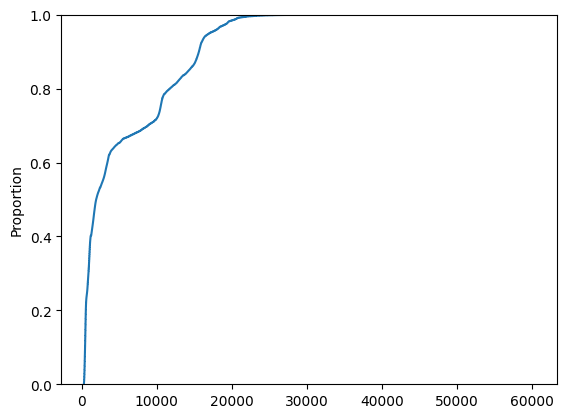

In [24]:
frame_sizes = []
for idx, row in df_grp.iterrows():
    frame_sizes.append(sum(row['udp.length']))
sns.ecdfplot(data=frame_sizes)

In [ ]:
df_grp = pd.read_csv('../Intermediates/' + data_folder.split('/')[-1]+'_df_grp.csv')

In [ ]:
df_grp[df_grp['vca'] == 'teams'].describe(percentiles=percentiles+[0.995])

In [ ]:
df_grp[df_grp['vca'] == 'meet'].describe(percentiles=percentiles+[0.995])

In [ ]:
plt.figure()
sns.ecdfplot(data=df_grp[df_grp['vca'] == 'teams'], x='inter')
sns.ecdfplot(data=df_grp[df_grp['vca'] == 'teams'], x='intra')
plt.show()

## QoE Estimation

In [80]:
stat_map = {}
data_merge_rtp = {}
data_merge_udp = {}

In [81]:
def is_freeze(x):
    if x["frame_dur"] > max(3*x["avg_frame_dur"], (x["avg_frame_dur"] + 0.150)): # Q: Based on previous work or experiments?
        return 1
    else:
        return 0

def get_freeze_dur(x):
    if x["is_freeze"] == 1:
        return x["frame_dur"]
    else:
        return 0
    

def get_net_stats(df_video, vca, ft_end_col="frame_et"):
    
    ## frame duration calculations
    df_video["frame_st"] = df_video["frame_st"].apply(lambda x: float(x))
    df_video["frame_et"] = df_video["frame_et"].apply(lambda x: float(x))
    df_video["frame_size"] = df_video["frame_size"].apply(lambda x: float(x))
    df_video["frame_dur"] = df_video[ft_end_col].diff()
    df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
    df_video = df_video.fillna(0)
    
    ## freeze calculation
    df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
    df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)
    
    ## obtain per second stats
    df_video["frame_et_int"] = df_video[ft_end_col].apply(lambda x: int(x))
    df_grp = df_video.groupby("frame_et_int").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'lost_frame_sum': 'frames_lost',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000    
    return df_grp

In [82]:
def get_video(df, vca, method="udp"):
    if method == "udp":
        df["is_video"] = df[df['vca'] == vca]['is_video_pred']
    elif method == "rtp":
        df["is_video"] = df[df['vca'] == vca]['is_video_actual']
    df_video = df[df["is_video"] == 1]
    return df_video
    
def get_media_conf_matrix(df_rtp, df_udp, log=True):
    cols = ['rtp.seq', 'is_video']
    df_rtp = df_rtp[cols]
    df_udp = df_udp[cols]
    df_merge = pd.merge(df_rtp, df_udp, on="rtp.seq", suffixes=("_rtp", "_udp"), how="left")
    df_merge = df_merge.fillna(0)
    cm = confusion_matrix(df_merge["is_video_rtp"], df_merge["is_video_udp"])
    if log:
        print(cm)
    return cm

def assign_frames_stat(df, size_diff_thresh):
    frame_id_assignment = []
    frame_id = 0
    max_pkt_size = {}
    avg_pkt_size = {}
    num_pkts = {}
    df['frame.time_relative'] = df['frame.time_relative'].astype(float)
    for i in range(0, df.shape[0]):
        curr_size = df.iloc[i]['udp.length']
        found = False
        for look_back in range(size_diff_thresh[vca]['look_back']):
            prev_frame_id = frame_id-look_back
            if prev_frame_id <= 0:
                break
            if abs(avg_pkt_size[prev_frame_id]-curr_size) <= size_diff_thresh[vca]['intra']:
                found = True
                frame_id_assignment.append(prev_frame_id)
                n = num_pkts[prev_frame_id]
                avg_pkt_size[prev_frame_id] = (avg_pkt_size[prev_frame_id]*n + curr_size)/(n+1)
                max_pkt_size[frame_id] = max(max_pkt_size[frame_id], curr_size)
                num_pkts[prev_frame_id] += 1
                break
        if not found:
            frame_id += 1
            frame_id_assignment.append(frame_id)
            max_pkt_size[frame_id] = curr_size
            avg_pkt_size[frame_id] = curr_size
            num_pkts[frame_id] = 1
    return frame_id_assignment

def assign_frames_ml(df, model):
    frame_id_assignment = [1]
    start = 1
    cols = ['label', 'udp.length', 'is_teams']
    df = df[cols]
    X_test = df.loc[:, df.columns != 'label'].to_numpy()
    y_test = model.predict(X_test)
    for i in range(1, len(df)):
        frame_id_assignment.append(frame_id_assignment[-1]+y_test[i])
    return frame_id_assignment

def get_frames_udp(df, vca, size_diff_thresh, windows=None, method='stat', model = None):
    # df["size_diff"] = df["udp.length"].diff().abs()
    
    if method == 'stat':
        frame_id_assignment = assign_frames_stat(df, size_diff_thresh)
    elif method == 'ml':
        frame_id_assignment = assign_frames_ml(df, model)
        
    df["frame.time_epoch"] = df["frame.time_epoch"].astype(float)
    df["frame_num"] = frame_id_assignment
    
    df['udp.length'] = df['udp.length'] - 12
    df_grp = df.groupby("frame_num").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
    df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
    df_grp["frame_length"] = df_grp["udp.length"].apply(lambda x: len(x))
    
    if windows:
        df_grp["ft_end"] = df_grp['frame_et'].apply(lambda x: get_window(x, windows))
    else:
        df_grp["ft_end"] = df_grp['frame_et'].apply(lambda x: int(x))
    
    frame_lengths = df_grp['frame_length']
    frame_sizes = df_grp['frame_size']
    
    ## frame duration calculations
    df_grp["frame_dur"] = df_grp["frame_et"].diff()
    df_grp["avg_frame_dur"] = df_grp["frame_dur"].rolling(30).mean() # Why 30?
    df_grp = df_grp.fillna(0)
    
    ## freeze calculation
    df_grp["is_freeze"] = df_grp.apply(is_freeze, axis=1)
    df_grp["freeze_dur"] = df_grp.apply(get_freeze_dur, axis=1)
    
    
    
    df_grp = df_grp.groupby("ft_end").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", 
                                            "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000
    df_grp['method'] = method
    #print(df_grp['ft_end'].head(2))
    return df_grp, frame_lengths, frame_sizes

def get_udp_per_second_stats(df, vca, windows=None):
    df["is_video_udp"] = df["udp.length"].apply(is_video_udp, vca=vca)
    df_video = df[df["is_video_udp"] == 1]
    df_grp = get_frames_udp(df_video, vca=vca, windows=windows)
    return df_grp  

In [83]:
# if first_run:
#     skip = {'Skip': [], 'Proportion': [], 'VCA': []}
#     for k in df_grp['file'].unique():
#         dfg = df_grp[df_grp['file'] == k]
#         vca = dfg['vca'].unique()[0]
#         thresh = 20 if vca == 'meet' else 3
#         for s in range(10):
#             tot = 0
#             mis = 0
#             for i in range(dfg.shape[0]):
#                 if i-s-1 < 0:
#                     continue
#                 tot += 1
#                 if abs(np.array(dfg.iloc[i]['udp.length']).mean() - np.array(dfg.iloc[i-s-1]['udp.length']).mean()) < thresh:
#                     found = False
#                     for s_ in range(s):
#                         if abs(np.array(dfg.iloc[i]['udp.length']).mean() - np.array(dfg.iloc[i-s_-1]['udp.length']).mean()) < thresh:
#                             found = True
#                             break
#                     if not found:
#                         mis += 1
#             skip['Skip'].append(s)
#             skip['Proportion'].append(100*mis/tot)
#             skip['VCA'].append(vca)
#     sd = pd.DataFrame(skip)

#     skip_df = sd.groupby(['Skip', 'VCA'])['Proportion'].mean().reset_index()
#     skip_df.to_csv('../Intermediates/' + data_folder.split('/')[-1]+'_skip_df.csv')

In [84]:
# skip_df = pd.load_csv('../Intermediates/' + data_folder.split('/')[-1]+'_df_grp.csv')
# sns.lineplot(data=skip_df, x = 'Skip', y = 'Proportion', hue='VCA')
# plt.grid()

In [85]:
# Train test split

# pattern_dict = {x: {v: [] for v in vcas} for x in range(len(patterns))}
# for idx, pattern in enumerate(patterns):
#     for k in file_map:
#         if pattern.match(k):
#             vca = file_map[k]['vca']
#             pattern_dict[idx][vca].append(k)
# train_files = []
# for p in range(len(patterns)):
#     for vca in pattern_dict[p].keys():
#         n_files = len(pattern_dict[p][vca])
#         for f in pattern_dict[p][vca][:n_files//2]:
#             train_files.append(f)
# test_files = [f for f in file_map.keys() if f not in train_files]
# print(len(train_files))
# print(len(test_files))

In [86]:
# Labelling

# max_packet_window_size = 20

# def label(files):
#     dfs = []
#     for k in files:
#         df_net = file_map[k]['pcap'].copy()
#         df_net["is_video"] = df_net[(df_net.vca == vca)]['is_video_actual']
#         df_net['is_teams'] = df_net['vca'].apply(lambda x: 0 if x == 'meet' else 1)
#         df_net['rtp.ts_rel_diff'] = df_net['rtp.ts_rel'].diff()
#         df_net['rtp.ts_rel_diff'].fillna(0, inplace=True)
#         df_net['rtp.ts_rel_diff'] = df_net['rtp.ts_rel_diff'].astype(int)
#         df_net.rename({'rtp.ts_rel_diff': 'label'}, axis=1, inplace=True)
#         df_net['label'] = df_net['label'].where(df_net['label'] < -2, -2)
#         # Windowed packet size difference
#         # for i in range(1, max_packet_window_size+1):
#         #     df_net[f'window_diff_{i}'] = df_net['udp.length'].diff(periods=i)
#         #     df_net[f'window_diff_{i}'].fillna(0, inplace=True)
#         dfs.append(df_net)

#     df = pd.concat(dfs)
#     return df

# train_df = label(train_files)
# cols = ['label', 'udp.length', 'is_teams']
# train_df = train_df[cols]
# X_train = train_df.loc[:, train_df.columns != 'label'].to_numpy()
# y_train = train_df['label'].to_numpy()

In [87]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# model.fit(X_train, y_train)

In [88]:
print(len(file_map))

460


In [100]:
stat_file = {}
for idx, k in enumerate(file_map):
    stat_lookback = {}
    vca = file_map[k]['vca']
    if (idx+1) % 10 == 0:
        print(f'{idx+1} of {len(file_map)}')
    # test_df = label([k])
    # df_frame_ml = get_frames_udp(test_df, vca=vca, size_diff_thresh=None, method='ml', model=model)
    for lookback in range(2, 3):
        size_diff_thresh = {"meet": {"intra" : 20, "look_back": lookback }, "teams": {"intra" : 4, "look_back": lookback }}
        ## Media classification
        df_net = file_map[k]['pcap']
        df_video_udp = get_video(df_net, vca=vca, method="udp")

        df_net["is_video"] = df_net[(df_net.vca == vca)]['is_video_actual']
        #cm = get_media_conf_matrix(df_net, df_video_udp, log=False)

        df_video_udp = df_video_udp.sort_values(by=['frame.time_relative'])
        
        ## Frame identification
        df_frame_udp, frame_lengths, frame_sizes = get_frames_udp(df_video_udp, vca=vca, size_diff_thresh=size_diff_thresh)
        
        ## RTP Frame identification
        df_rtp = df_net[df_net["is_video"] == 1]
        df_grp = df_rtp.groupby("rtp.timestamp").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
        df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
        df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
        df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
        
        if lookback == 2 and k == 'chrome-5-0-50-0-2-0.7-1667428139-1667428252.json':
            r = list(df_rtp.sort_values('frame.time_relative').groupby(['rtp.ts_rel']).size())
            u = list(frame_lengths)
            x1 = range(len(r))
            x2 = range(len(u))
            plt.figure(figsize=(22, 4))
            plt.bar(x1, r, color='b')
            plt.plot(x2, u, color='r')
            plt.xlabel('Frame #')
            plt.ylabel('Number of packets')
            plt.legend(labels=['UDP', 'RTP'])
            plt.grid()
            plt.show()
            plt.savefig('plots/frame_length_vs_id.png')
            
            plt.figure()
            sns.ecdfplot(data=u, color='r')
            sns.ecdfplot(data=r, color='b')
            plt.xlabel('Frame length')
            plt.grid()
            plt.legend(labels=['UDP', 'RTP'])
            plt.show()
            plt.savefig('plots/frame_length_cdf.png')
            
            sr = list(df_rtp.sort_values('frame.time_relative').groupby(['rtp.ts_rel'])['udp.length'].sum())
            su = list(frame_sizes)
            x1 = range(len(sr))
            x2 = range(len(su))
            plt.figure(figsize=(22, 4))
            plt.bar(x1, sr, color='b')
            plt.plot(x2, su, color='r')
            plt.xlabel('Frame #')
            plt.ylabel('Number of bytes')
            plt.legend(labels=['UDP', 'RTP'])
            plt.grid()
            plt.show()
            plt.savefig('plots/frame_size_vs_id.png')
            
            plt.figure()
            sns.ecdfplot(data=su, color='r')
            sns.ecdfplot(data=sr, color='b')
            plt.xlabel('Frame size')
            plt.grid()
            plt.legend(labels=['UDP', 'RTP'])
            plt.show()
            plt.savefig('plots/frame_size_cdf.png')
            
            
        df_webrtc = file_map[k]['webrtc']
        stat_lookback[lookback] = {"webrtc": df_webrtc, "rtp": df_grp,"udp": df_frame_udp, "vca": vca}
        # stat_lookback[lookback] = {"webrtc": df_webrtc, "rtp": df_grp,"udp": df_frame_udp, "vca": vca, "ml": df_frame_ml}
    stat_file[k] = stat_lookback
    
if first_run:
    with open('../Intermediates/' + data_folder.split('/')[-1]+'_stat_file.pkl', 'wb') as handle:
        pickle.dump(stat_file, handle, protocol=pickle.HIGHEST_PROTOCOL)

10 of 460
20 of 460
30 of 460
40 of 460
50 of 460
1667885469.7720728
1667885470
60 of 460
70 of 460
80 of 460
90 of 460
100 of 460
110 of 460
120 of 460
130 of 460
140 of 460
150 of 460
160 of 460
170 of 460
180 of 460
190 of 460
200 of 460
210 of 460
220 of 460
230 of 460
240 of 460
250 of 460
260 of 460
270 of 460
280 of 460
290 of 460
300 of 460
310 of 460
320 of 460
330 of 460
340 of 460
350 of 460
360 of 460
370 of 460
380 of 460
390 of 460
400 of 460
410 of 460
420 of 460
430 of 460
440 of 460
450 of 460
460 of 460


In [103]:
print(len(file_map))

460


In [104]:
# with open('../Intermediates/' + data_folder.split('/')[-1]+'_stat_file.pkl', 'rb') as handle:
#     stat_file = pickle.load(handle)

if first_run:
    dfs_udp = []
    dfs_rtp = []
    # dfs_ml = []
    for idx, k in enumerate(stat_file):
        # print(k)
        if (idx+1) % 10 == 0:
            print(f'{idx+1} of {len(file_map)}')
        vca = file_map[k]['vca']
        # print(vca)
        for lookback in stat_file[k].keys():
            df_webrtc = stat_file[k][lookback]['webrtc']
            df_webrtc["bitrate_gt"] = df_webrtc['[bytesReceived_in_bits/s]'] / 1000
            df_webrtc["interFrameDelayStDev_in_s"] = df_webrtc['[interFrameDelayStDev_in_ms]'] / 1000

            col = "ft_end"
            df_net_udp = stat_file[k][lookback]['udp']
            # df_net_ml = stat_file[k][lookback]['ml']

            #df_grp_udp = get_(df_net_udp)
            df_merge_udp = pd.merge(df_net_udp, df_webrtc, left_on=col, right_on="ts")
            df_merge_udp["file"] = k
            df_merge_udp["vca"] = vca
            df_merge_udp['lookback'] = lookback
            dfs_udp.append(df_merge_udp)

            df_net_rtp = stat_file[k][lookback]['rtp']
            df_net_rtp['frame_num'] = df_net_rtp['rtp.timestamp']

            col = "frame_et_int"
            df_grp_rtp = get_net_stats(df_net_rtp, vca=vca)
            if k == 'chrome-5-0-50-0-2-0.0-1667885436-1667885508.json':
                print(df_grp_rtp[col].unique(), df_webrtc['ts'].unique())
            df_merge_rtp = pd.merge(df_grp_rtp, df_webrtc, left_on=col, right_on="ts")
            df_merge_rtp["file"] = k
            df_merge_rtp["vca"] = vca
            df_merge_rtp["lookback"] = lookback
            
            # print(df_merge_rtp['file'])
            
            dfs_rtp.append(df_merge_rtp)
    data_merge_rtp = pd.concat(dfs_rtp).reset_index(drop=True)
    data_merge_udp = pd.concat(dfs_udp).reset_index(drop=True)
    
    data_merge_rtp.to_csv('../Intermediates/' + data_folder.split('/')[-1]+'_data_merge_rtp.csv')
    data_merge_udp.to_csv('../Intermediates/' + data_folder.split('/')[-1]+'_data_merge_udp.csv')
# data_merge_ml = pd.concat(dfs_ml).reset_index(drop=True)

10 of 460
20 of 460
30 of 460
40 of 460
50 of 460
[1667885470 1667885471 1667885472 1667885473 1667885474 1667885475
 1667885476 1667885477 1667885478 1667885479 1667885480 1667885481
 1667885482 1667885483 1667885484 1667885485 1667885486 1667885487
 1667885488 1667885489 1667885490 1667885491 1667885492 1667885493
 1667885494 1667885495 1667885496 1667885497] [1667885469 1667885470 1667885471 1667885472 1667885473 1667885474
 1667885475 1667885476 1667885477 1667885478 1667885479 1667885480
 1667885481 1667885482 1667885483 1667885484 1667885485 1667885486
 1667885487 1667885488 1667885489 1667885490 1667885491 1667885492
 1667885493 1667885494 1667885495 1667885496 1667885497 1667885498
 1667885499 1667885500 1667885501 1667885502]
60 of 460
70 of 460
80 of 460
90 of 460
100 of 460
110 of 460
120 of 460
130 of 460
140 of 460
150 of 460
160 of 460
170 of 460
180 of 460
190 of 460
200 of 460
210 of 460
220 of 460
230 of 460
240 of 460
250 of 460
260 of 460
270 of 460
280 of 460
290 of

In [105]:
# data_merge_rtp = pd.concat(dfs_rtp).reset_index(drop=True)
# data_merge_udp = pd.concat(dfs_udp).reset_index(drop=True)
print(dfs_rtp[0]["file"].unique())


['chrome-2-0-0-0-0-0-1667932289-1667932353.json']


In [107]:
col_map = {'fps': 'framesPerSecond', 'freeze_dur': 'totalFreezesDuration*',
          'bitrate': 'bitrate_gt', 'freeze_count': 'freezeCount*',
          'interframe_delay_std': 'interFrameDelayStDev_in_s'}

# data_merge_rtp = pd.read_csv('../Intermediates/' + data_folder.split('/')[-1]+'_data_merge_rtp.csv')
# data_merge_udp = pd.read_csv('../Intermediates/' + data_folder.split('/')[-1]+'_data_merge_udp.csv')

# err_map = {}
# interval_list = range(1, 2)
# for vca in vcas:
#     for k in data_merge_udp[vca]["file"].unique():
#         print(vca, k)
#         df_merge_rtp = data_merge_rtp[vca]
#         df_merge_udp = data_merge_udp[vca]
#         for col in col_map:
#             col_webrtc = col_map[col]
#             for interval in interval_list:
#                 df_grp_rtp = df_merge_rtp[df_merge_rtp["file"] == k][[col, col_webrtc]].rolling(interval).mean()
#                 df_grp_rtp = df_grp_rtp.dropna()
#                 rmse_rtp =  mean_absolute_error(df_grp_rtp[col], df_grp_rtp[col_webrtc])

#                 df_grp_udp = df_merge_udp[df_merge_udp["file"] == k][[col, col_webrtc]].rolling(interval).mean()
#                 df_grp_udp = df_grp_udp.dropna()
#                 rmse_udp =  mean_absolute_error(df_grp_udp[col], df_grp_udp[col_webrtc])

#                 print("%s,%d,%.3f,%.3f, %.3f" % (col, interval, rmse_rtp, rmse_udp, rmse_udp - rmse_rtp))


chrome-3-0-0-0-0-0-1667867029-1667867101.json
[18. 14. 16. 25. 23. 25. 25. 24. 25. 25. 25. 25. 22. 28. 22. 28. 22. 27.
 23. 26. 23. 27. 23. 27. 24. 27. 23. 26.]
chrome-3-0-0-0-0-0-1667866920-1667866992.json
[25. 18. 14. 15. 25. 23. 24. 23. 26. 26. 25. 25. 24. 25. 25. 25. 25. 25.
 25. 23. 26. 25. 24. 26. 25. 24. 25. 24.]
chrome-3-0-0-0-0-0-1667867246-1667867318.json
[ 14.  25.  20.  24.  25.  24.  24.  25.  25.  25.  25.  25.  25.  25.
  25.  18. 153.]
chrome-3-0-0-0-0-0-1667867138-1667867209.json
[24. 26. 23. 27. 15. 23. 22. 26. 25. 24. 25. 25. 25. 24. 24. 26. 24. 25.
 24. 26. 24. 26. 23. 27. 24. 26.]
chrome-3-0-0-0-0-0-1667866811-1667866883.json
[25. 24. 24. 24. 25. 25. 25. 25. 25. 23. 27. 23. 26. 24. 26. 24. 26. 22.
 27. 22. 28. 22. 27. 23. 27.]


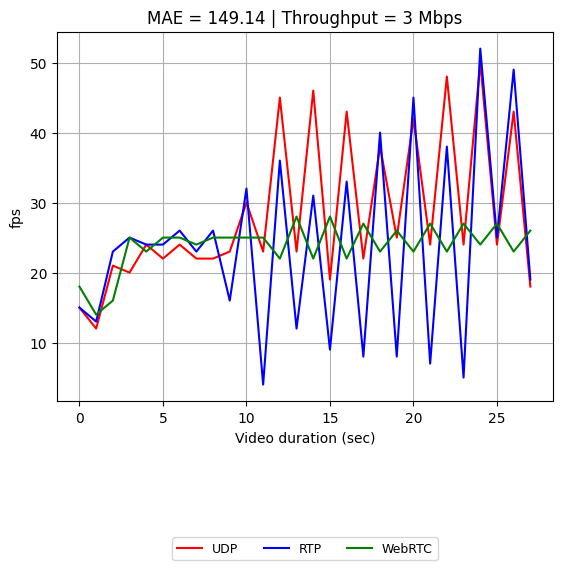

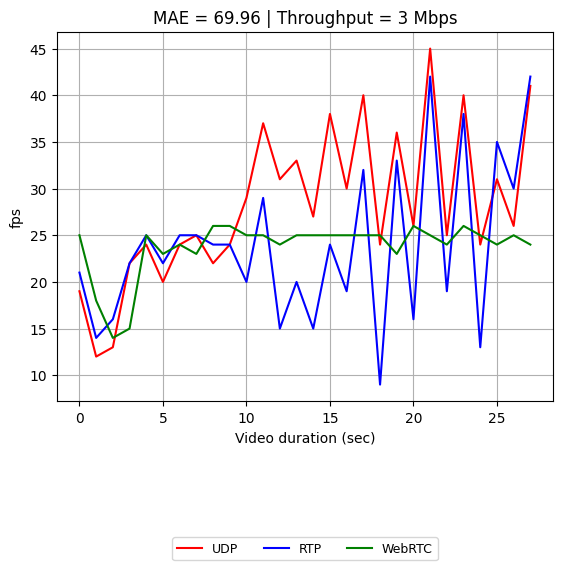

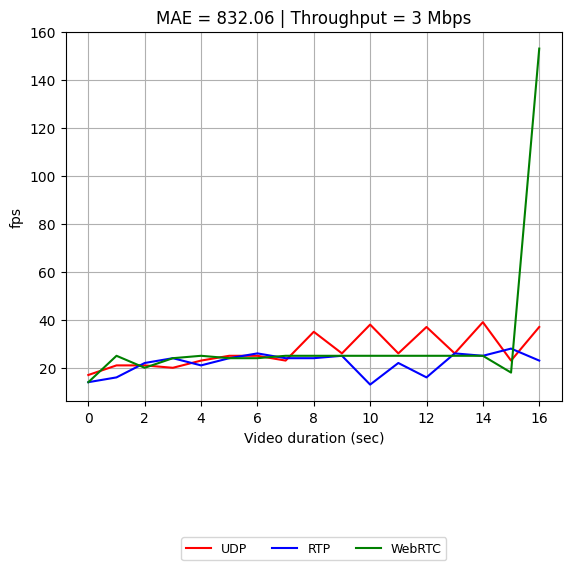

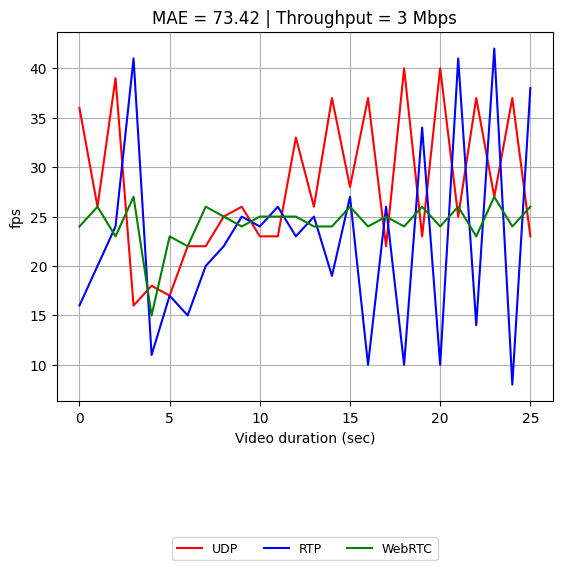

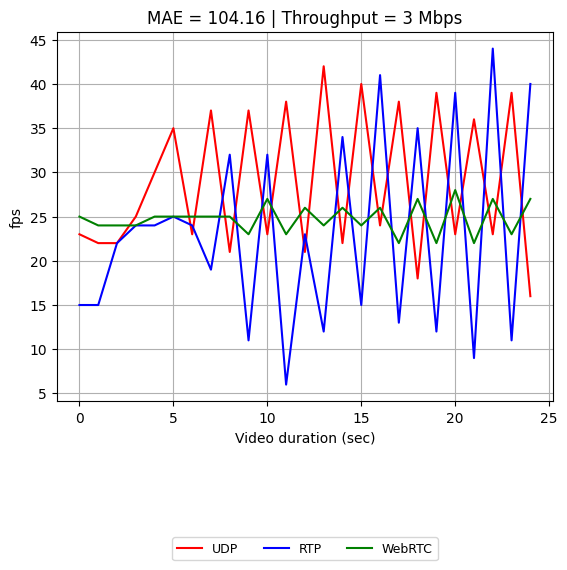

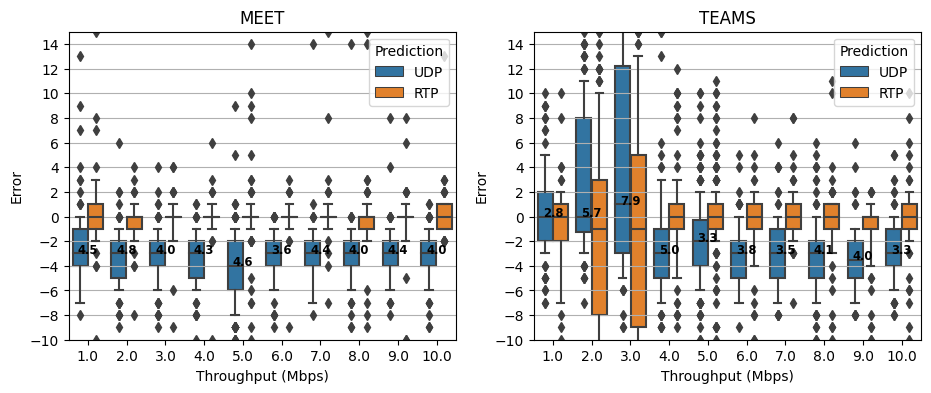

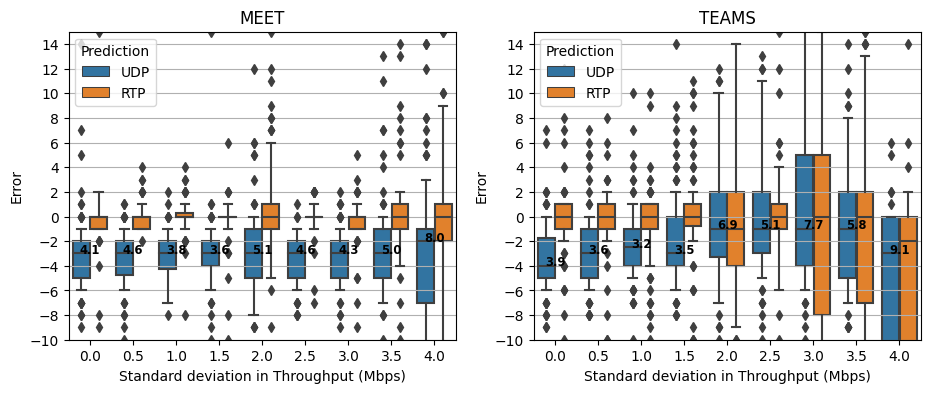

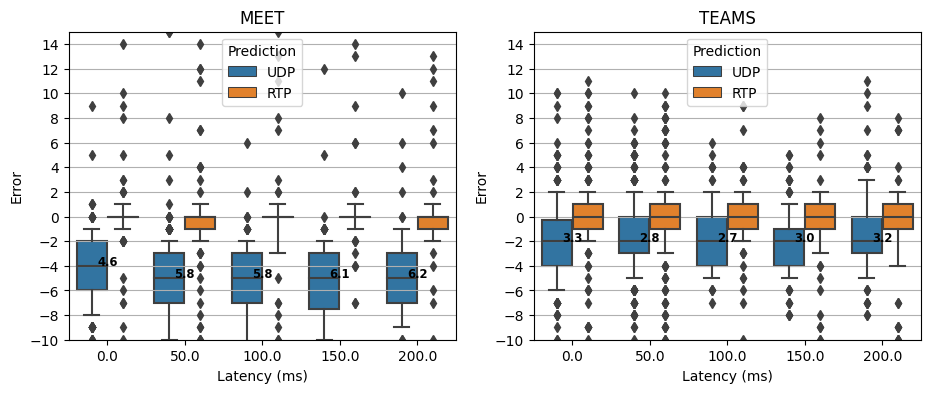

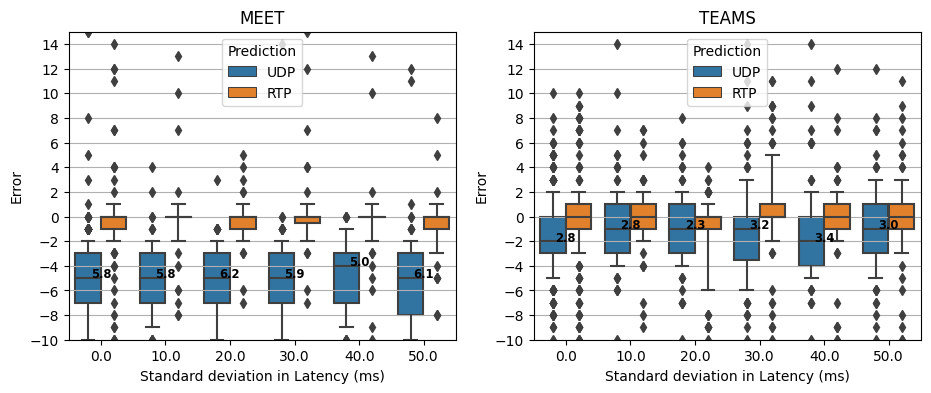

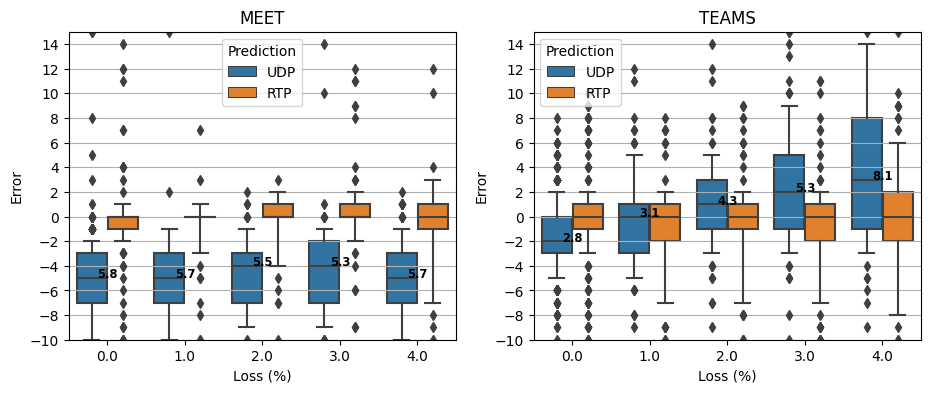

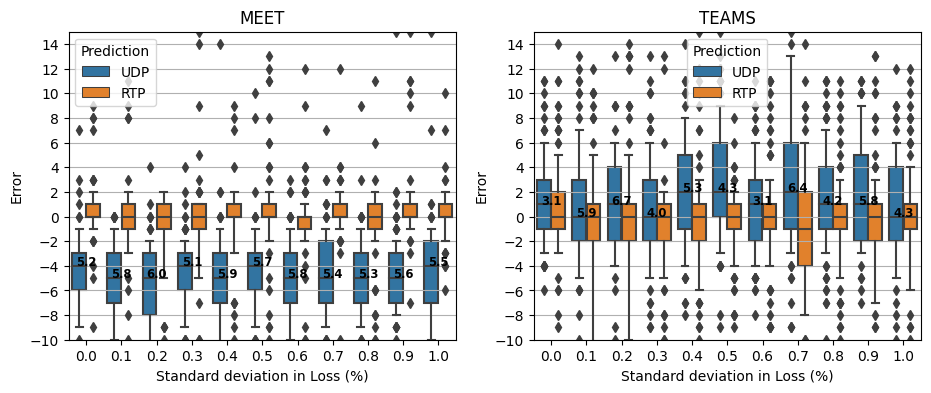

In [123]:
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})
import re
import math

interval = 1
col = 'fps'
lookback = 2
col_webrtc = col_map[col]

for idx, pattern in enumerate(patterns):
    if idx == 0:
        colname = 'Throughput (Mbps)'
    elif idx == 1:
        colname = 'Standard deviation in Throughput (Mbps)'
    if idx == 2:
        colname = 'Latency (ms)'
    elif idx == 3:
        colname = 'Standard deviation in Latency (ms)'
    if idx == 4:
        colname = 'Loss (%)'
    elif idx == 5:
        colname = 'Standard deviation in Loss (%)'

    error_dict = {'Error': [], 'Prediction Type': [], 'VCA' : [], colname: []}
    rtp = []
    udp = []
    # ml = []
    webrtc = []
    for k in data_merge_rtp["file"].unique():
        if pattern.match(k):
            name_split = k.split('-')
            
            vca = data_merge_udp[data_merge_udp['file'] == k]['vca'].unique()[0]
            col_value = float(name_split[idx+1])
            
            df_grp_webrtc = data_merge_udp[(data_merge_udp["file"] == k) & (data_merge_udp["lookback"] == lookback)][col_webrtc].rolling(interval).mean()
            df_grp_webrtc = df_grp_webrtc[~df_grp_webrtc.isna()]
            
            df_grp_rtp = data_merge_rtp[(data_merge_rtp["file"] == k) & (data_merge_rtp["lookback"] == lookback)][col].rolling(interval).mean()
            df_grp_rtp = df_grp_rtp[~df_grp_rtp.isna()]
            
            df_grp_udp = data_merge_udp[(data_merge_udp["file"] == k) & (data_merge_udp["lookback"] == lookback)][col].rolling(interval).mean()
            df_grp_udp = df_grp_udp[~df_grp_udp.isna()]
            # df_grp_udp = df_grp_udp.iloc[indexes]
            
            rtp_idx = set(df_grp_rtp.index.tolist())
            webrtc_idx = set(df_grp_webrtc.index.tolist())
            udp_idx = set(df_grp_udp.index.tolist())
            
            common_idx = rtp_idx.intersection(webrtc_idx).intersection(udp_idx)
            
            rtp_arr = np.array([df_grp_rtp.loc[i] for i in common_idx])
            webrtc_arr = np.array([df_grp_webrtc.loc[i] for i in common_idx])
            udp_arr = np.array([df_grp_udp.loc[i] for i in common_idx])

            rtp += list(rtp_arr)
            udp += list(webrtc_arr)
            webrtc += list(udp_arr)
            # ml += list(df_grp_ml)
            
            rtp_error_list = (rtp_arr-webrtc_arr).tolist()                
            error_dict['Error'] += rtp_error_list
            error_dict['Prediction Type'] += ['RTP']*len(rtp_error_list)
            error_dict['VCA'] += [vca for _ in range(len(rtp_error_list))]
            error_dict[colname] += [col_value for _ in range(len(rtp_error_list))]

            udp_error_list = (udp_arr-webrtc_arr).tolist()
            error_dict['Error'] += udp_error_list
            error_dict['Prediction Type'] += ['UDP']*len(udp_error_list)
            error_dict['VCA'] += [vca for _ in range(len(udp_error_list))]
            error_dict[colname] += [col_value for _ in range(len(udp_error_list))]
            
            if 'chrome-3-0-0-0-0-0' in k and vca == 'teams':
                print(k)
                plt.figure()
                x = np.arange(len(rtp_arr))
                mae = mean_squared_error(udp_arr, webrtc_arr)
                plt.title(f'MAE = {round(mae, 2)} | Throughput = 3 Mbps')
                print(webrtc_arr)
                plt.plot(x, udp_arr, color='red', label='UDP')
                plt.plot(x, rtp_arr, color='blue', label='RTP')
                plt.plot(x, webrtc_arr, color='green', label='WebRTC')
                plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=3, prop=dict(size=9))
                plt.savefig('plots/'+k[:-5]+'.png')
                # if col == 'fps':
                #     plt.ylim([0, 35])
                plt.xlabel('Video duration (sec)')
                plt.ylabel(f'{col}')
                plt.grid()
    vca_mae = {}
    for vca in vcas:
        rtp_vca = []
        udp_vca = []
        ml_vca = []
        webrtc_vca = []
        rtp_i = 0
        udp_i = 0
        ml_i = 0
        for i, x in enumerate(error_dict['VCA']):
            if x == vca:
                if error_dict['Prediction Type'][i] == 'RTP':
                    rtp_vca.append(rtp[rtp_i])
                    webrtc_vca.append(webrtc[rtp_i])
                    rtp_i += 1
                elif error_dict['Prediction Type'][i] == 'UDP':
                    udp_vca.append(udp[udp_i])
                    udp_i += 1
        rtp_mae = mean_absolute_error(np.array(webrtc_vca), np.array(rtp_vca))
        udp_mae = mean_absolute_error(np.array(webrtc_vca), np.array(udp_vca))
        vca_mae[vca] = {'rtp': rtp_mae, 'udp': udp_mae}
        
    for i, c in enumerate(error_dict['Prediction Type']):
        rtp_mae = vca_mae[error_dict['VCA'][i]]['rtp']
        udp_mae = vca_mae[error_dict['VCA'][i]]['udp']
        # ml_rmse = vca_rmse[error_dict['VCA'][i]]['ml']
        if c == 'RTP':
            c += f' | MAE = {rtp_mae}'
        elif c == 'UDP':
            c += f' | MAE = {udp_mae}'
        error_dict['Prediction Type'][i] = c
        # elif c == 'ML':
        #     c += f' | RMSE = {udp_rmse}'
        #     error_dict['Prediction Type'][i] = c
            
    error_df = pd.DataFrame(error_dict)
    fig, ax = plt.subplots(nrows = 1, ncols = len(vcas), figsize=(11, 4))
    for i, vca in enumerate(vcas):
        ax[i].grid(visible = 1)
        data1 = error_df[(error_df['VCA'] == vca) & (error_df['Prediction Type'].str.startswith('UDP'))]
        data2 = error_df[(error_df['VCA'] == vca) & (error_df['Prediction Type'].str.startswith('RTP'))]
        
        data1['Prediction'] = 'UDP'
        data2['Prediction'] = 'RTP'
        
        data = pd.concat([data1, data2], axis=0)
        
        box_plot1 = sns.boxplot(data=data, x = colname, y = "Error", whis = [10, 90], ax = ax[i], hue='Prediction')
        box_plot1.set_title(vca.upper())
        ax[i].set_ylim([-10, 15])
        ax[i].set_yticks(np.arange(-10, 15, 2))
        e_list1 = data1.groupby([colname]).agg({'Error': list}).reset_index()
        e_list1 = e_list1['Error'].apply(lambda l: sum(map(lambda x:abs(x),l))/len(l)).to_list()
        
        nobs1 = [str(round(x, 1)) for x in e_list1]
        medians1 = data1.groupby([colname])['Error'].median().values
        pos1 = range(len(nobs1))
        
        for tick,label in zip(pos1, ax[i].get_xticklabels()):
            ax[i].text(pos1[tick],
                medians1[tick] + 0.02,
                nobs1[tick],
                horizontalalignment='center',
                size='small',
                color='black',
                weight='semibold'
            )
            
    fname = 'plots/'+'_'.join(colname.lower().split()[:-1])+'.png'
    fig.savefig(fname)
    plt.show()

In [ ]:
for vca in vcas:
    plt.figure()
    plt.grid(visible=1)
    plt.xlim([-10, 10])
    sns.ecdfplot(data=error_df[error_df['VCA'] == vca], x = 'Error', hue='Prediction Type').set(xlabel = 'FPS error', ylabel='CDF', title=vca.upper())
    plt.savefig(f'plots/cdf_fps_error_vs_pred_type_{vca}.pdf')
    plt.show()

In [ ]:
interval = 1
col = 'fps'
col_webrtc = col_map[col]
rmse_dict = {'MAE': [], "Lookback": [], 'VCA': []}
error = []
config = []
for l in data_merge_udp["lookback"].unique():
    for vca in vcas:
        df_grp_rtp = data_merge_rtp[(data_merge_rtp["lookback"] == l) & (data_merge_rtp["vca"] == vca)][col].rolling(interval).mean()
        df_grp_rtp[np.isnan(df_grp_rtp)] = 0
        df_grp_udp = data_merge_udp[(data_merge_udp["lookback"] == l) & (data_merge_udp["vca"] == vca)][col].rolling(interval).mean()
        df_grp_udp[np.isnan(df_grp_udp)] = 0
        df_grp_webrtc = data_merge_udp[(data_merge_udp["lookback"] == l) & (data_merge_udp["vca"] == vca)][col_webrtc].rolling(interval).mean()
        df_grp_webrtc[np.isnan(df_grp_webrtc)] = 0
        rmse_udp = mean_absolute_error(df_grp_udp.to_numpy(), df_grp_webrtc.to_numpy())
        rmse_dict['MAE'].append(rmse_udp)
        rmse_dict['Lookback'].append(l)
        rmse_dict['VCA'].append(vca)
lookback_df = pd.DataFrame(rmse_dict)
l_meet = lookback_df[lookback_df['VCA'] == 'meet']
l_teams = lookback_df[lookback_df['VCA'] == 'teams']
ax = l_meet[['MAE', 'Lookback']].plot(x='Lookback', y='MAE', label='Meet', marker = 'o')
l_teams[['MAE', 'Lookback']].plot(x='Lookback', y='MAE', ax=ax, label='Teams', marker = 'o')
ax.set_ylabel('MAE')
plt.grid(visible=1)
plt.xticks(range(11))
plt.savefig('plots/look_back_mae.pdf')

In [ ]:
df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(lambda x: x if ',' not in x else -1)
sns.ecdfplot(data=df_net, x="udp.length", hue="rtp.p_type")
# df_net[df_net['rtp.p_type'] == 121]['udp.length'].describe(percentiles=[0.5, 0.75, 0.9, 0.99])

In [ ]:
df_net.groupby('rtp.p_type')['udp.length'].agg([np.mean, max, min])

In [ ]:
df_grp["num.frames"] = df_grp["udp.length"].apply(lambda x: len(x))#.describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
sns.ecdfplot(df_grp["num.frames"])

In [ ]:
for k in file_map:
    df_net = file_map[k]['pcap']

In [ ]:
df_net["is_video"] = df_net["udp.length"].apply(lambda x: is_video_(x, vca=vca))
df_net["is_video_rtp"] = df_net["rtp.p_type"].apply(lambda x: is_video_rtp(x, vca=vca))
print(confusion_matrix(df_net["is_video"], df_net["is_video_rtp"]))
#df_net["iat"] = df_net["frame.time_epoch"].diff()
#df_net

In [ ]:
max_diff = 5
df_net = df_net.sort_values(by="frame.time_relative")
df_video = df_net[df_net["is_video"] == 1]
df_video["time_diff"] = df_video["frame.time_relative"].diff()
df_video["size_diff"] = df_video["udp.length"].diff()
df_video["new_frame"] = 0
df_video["new_frame"].iat[0] = 1
for i in range(1, df_video.shape[0]):
    size_diff = abs(df_video.iloc[i]["size_diff"])
    if size_diff > 30:
        df_video["new_frame"].iat[i] =  1
df_video["new_frame"].value_counts()
df_small = df_video[["frame.time_relative", "new_frame", "size_diff", "time_diff"]]
df_merge = pd.merge(df_net, df_small, on="frame.time_relative")

In [ ]:
pd.options.display.max_rows = 1000
cols = ["frame.time_relative", "udp.length", "size_diff", "rtp.timestamp", "new_frame"]
df_net[df_net["is_video_rtp"] == 1]["rtp.timestamp"].unique().shape
df_video_rtp = df_net[df_net["is_video_rtp"] == 1] 
df_video_rtp["new_frame"] = df_video_rtp["new_frame"].apply(lambda x: x if not pd.isna(x) else 0)
df_grp = df_video_rtp.groupby("rtp.timestamp")["new_frame"].apply("sum").reset_index()

In [ ]:
sns.ecdfplot(df_filter['udp.length'])

In [ ]:
#sns.ecdfplot(data=df_net, x="udp.length", hue="rtp.p_type")

In [ ]:
df_grp1.head(100)

In [ ]:
i = 0
for k in file_map:
    df_net1 = file_map[k]['pcap']
    df_net1 = df_net1[~df_net1["rtp.p_type"].str.contains(",")]
    df_audio = df_net1[df_net1["rtp.p_type"] == "111"]
    print(df_audio["udp.length"].value_counts())
    i += 1
    if i == 10:
        break